In [44]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.container { font-size:16px !important; }</style>"))

import numpy as np 
import matplotlib.pyplot as plt 

from matplotlib import rcParams
#rcParams['font.family'] = 'sans'
#rcParams['font.sans-serif'] = ['Tahoma']
rcParams['font.size'] = 22
#rcParams['text.usetex'] = True
import matplotlib.pyplot as plt

import emcee 
import corner
from astropy.io import fits 

Our goal for today is to fit some data. We are going to use physically motivated model to relate Stokes I and Stokes V and to obtain longitudinal magnetic field. Weak field approximation implies that: 

$$V = -4.69\times 10^{-13} \frac{dI}{d\lambda}\lambda^2 g_L B_n $$

Where $g_L$ is the Lande factor of the line, $B_n$ is transversal magnetic field and $\lambda$ is the wavelength of the line. Since we are talking about a very small range of wavelenghts, we can use line center wavelenght here. Let's take some HINODE plage data and try to infer some magnetic fields ;-)

In [45]:
stokes = fits.open("/home/milic/data/Hinode_network/hinode_network_c.fits")[0].data
print(stokes.shape)

(512, 873, 4, 112)


Text(0.5, 1.0, 'Continuum intensity map')

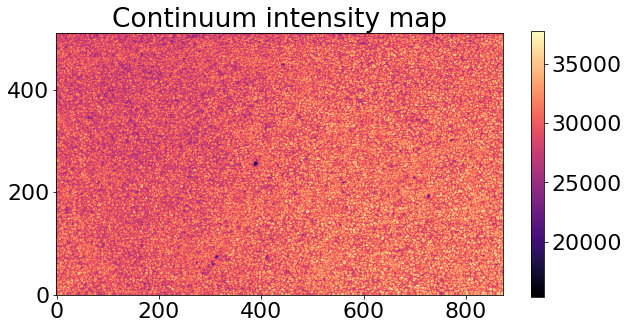

In [46]:
plt.figure(figsize=[10,7])
plt.imshow(stokes[:,:,0,0],origin='Lower',cmap='magma')
plt.colorbar(shrink=0.7)
plt.title("Continuum intensity map")

The next step is to figure out our wavelength grid. In principle we could do calibration but nice HINODE people already did that for us and there is a scale in the header of the individual files that I have used to assemble this. Let's take a look at that:

In [47]:
example = fits.open("/home/milic/data/Hinode_network/SP3D20120404_021106.1C.fits")
example[0].header

SIMPLE  =                    T /image conforms to FITS standard                 
BITPIX  =                   16 /bits per data value                             
NAXIS   =                    3 /number of axes                                  
NAXIS1  =                  112 /                                                
NAXIS2  =                  512 /                                                
NAXIS3  =                    4 /                                                
EXTEND  =                    T /file may contain extensions                     
DATE    = '2012-04-09T15:31:41.000' /                                           
DATE_RF0= '2012-04-09T15:31:41.000' /                                           
TELESCOP= 'HINODE  '           /                                                
INSTRUME= 'SOT/SP  '           /                                                
MDP_CLK =        3519292774.00 /                                                
ORIGIN  = 'JAXA/ISAS, SIRIUS

CRPIX1  =              56.5000 /                                                
CRVAL1  =              6302.08 / 

These two lines are telling us that pixel "number" 56.5 has wavelenght of 6302.08 Angstroms. Sampling is 0.0215 Angstroms per pixel. (Wrongly quoted as "resolution" here): 

https://hesperia.gsfc.nasa.gov/ssw/hinode/sot/doc/guide/SAGv3.3.pdf

In [49]:
# So, to make wavelength, let's do something like this. 
NL = 112 
ll = np.linspace(0,NL-1,NL)
ll = 6302.08 + (ll-56.5)*0.0215

Now, it would be good to take a look at the whole spectrum to see where we expect the peak of the polarization, because we want to take a look at Stokes V map

Text(0, 0.5, 'Stokes I')

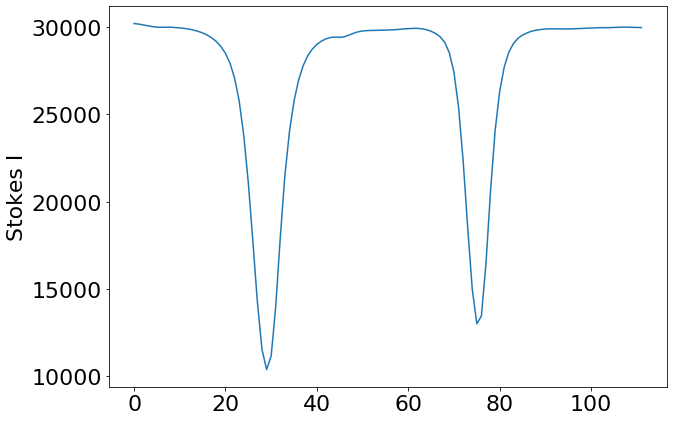

In [50]:
mean = np.mean(stokes,axis=(0,1))
plt.figure(figsize=[10,7])
plt.plot(mean[0])
plt.ylabel("Stokes I")

Text(0.5, 1.0, 'Stokes V in the blue wing of 6301.5')

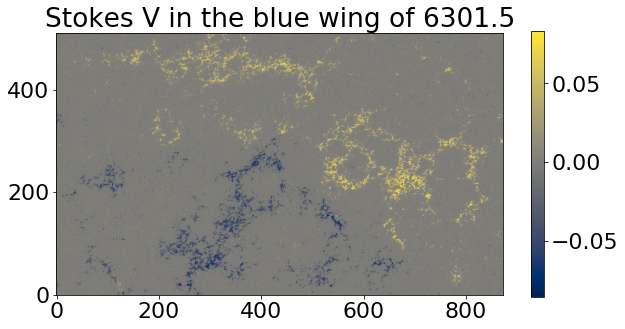

In [51]:
#Looks like we can take ~ index 23 or so for the blue wing of 6301.5 line

plt.figure(figsize=[10,7])
plt.imshow(stokes[:,:,3,23]/mean[0,0],origin='Lower',cmap='cividis')
plt.colorbar(shrink=0.7)
plt.title("Stokes V in the blue wing of 6301.5")

Looks like the point with index ~ (250,700) (remember Python plots reverse Axes)

Let's plot Stokes I and V

Text(0, 0.5, 'Stokes $V$')

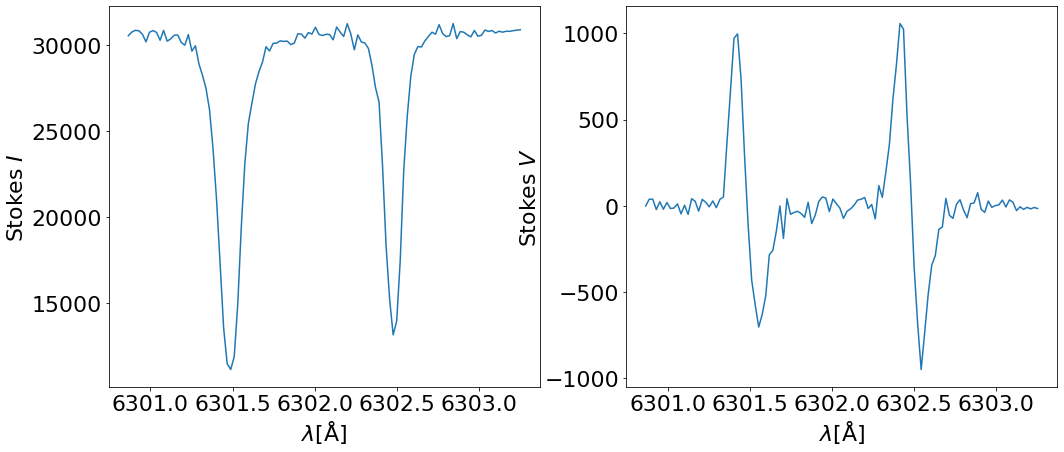

In [52]:
i = 250
j = 700

plt.figure(figsize=[17,7])
plt.subplot(121)
plt.plot(ll,stokes[i,j,0])
plt.xlabel("$\\lambda \mathrm{[\\AA]}$")
plt.ylabel("Stokes $I$")
plt.subplot(122)
plt.plot(ll,stokes[i,j,3])
plt.xlabel("$\\lambda \mathrm{[\\AA]}$")
plt.ylabel("Stokes $V$")

Wow the shape of the Stokes V really does look like the shape of the derivative of the Stokes I. Let's check that. 

Text(0, 0.5, 'Stokes $V$')

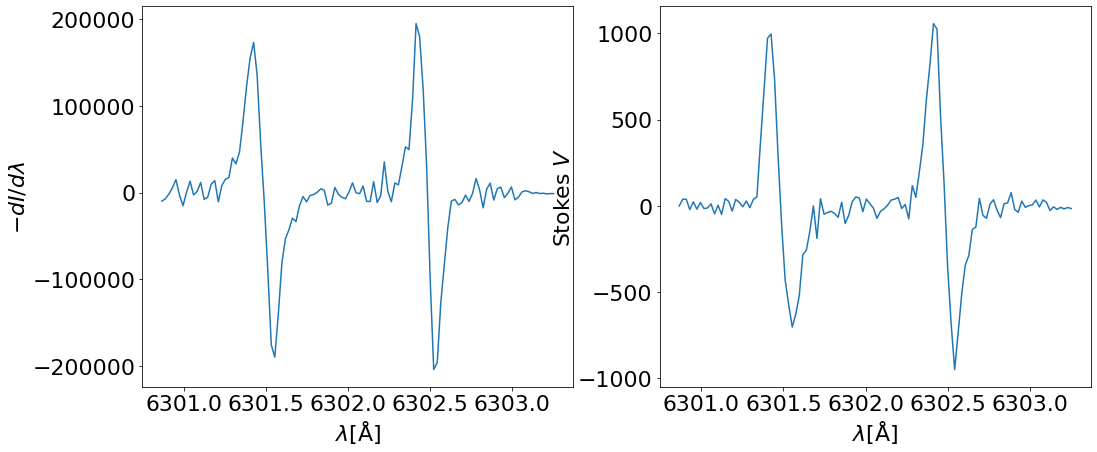

In [53]:
i = 250
j = 700

#There is a built in function called gradient that does this. Remember that V ~ -dI/dlambda
dI_dl = np.gradient(stokes[i,j,0])/np.gradient(ll)

plt.figure(figsize=[17,7])
plt.subplot(121)
plt.plot(ll,-dI_dl)
plt.xlabel("$\\lambda \mathrm{[\\AA]}$")
plt.ylabel("$-dI/d\\lambda$")
plt.subplot(122)
plt.plot(ll,stokes[i,j,3])
plt.xlabel("$\\lambda \mathrm{[\\AA]}$")
plt.ylabel("Stokes $V$")

Now next step is to calculate the magnetic field from this. As we said V is directly propotional to $dI/d\lambda$. So I can fit V to $dI/d\lambda$!!!! For starters using just matrix inversion. Note that we have to treat the two lines separately as they have different lande factors. 

Text(0, 0.5, 'V')

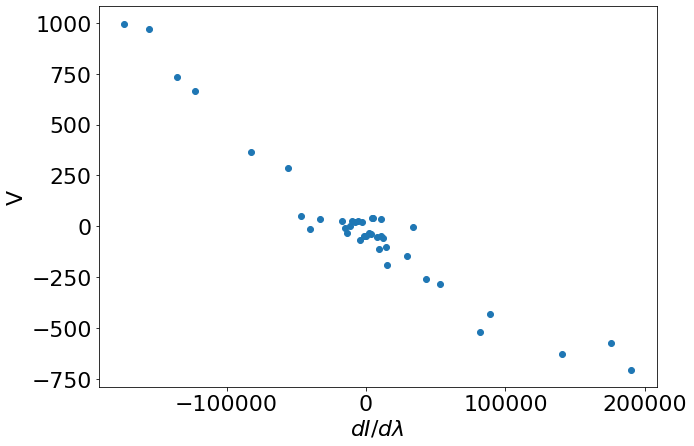

In [55]:
# Let's do a plot:
plt.figure(figsize=[10,7])
plt.plot(dI_dl[10:50],stokes[i,j,3,10:50],'o')
plt.xlabel("$dI/d\lambda$")
plt.ylabel("V")

We want to fit this with a linear function now, that is basically something like this:
$$k x +n =y $$
Or written as a matrix equation, keep in mind $k$ and $n$ are unknowns...
$$(\vec{x} , \vec{1})(k,n)^T = y$$ 

We have an overdetermined system: 
$$ a x = b$$ 
We are solving it using pseudoinverse! 

In [56]:
#Let's do the fit
# number of data
ND = 40
a = np.zeros([ND,2])
a[:,0] = dI_dl[10:50]
a[:,1] = 1.0
b = stokes[i,j,3,10:50]

a_inv = np.linalg.pinv(a)

p = np.linalg.inv((a_inv @ a))@ (a_inv @ b)
print (p)

[-0.00467672 -1.15015014]


Let's see if this makes sense

Text(0, 0.5, 'V')

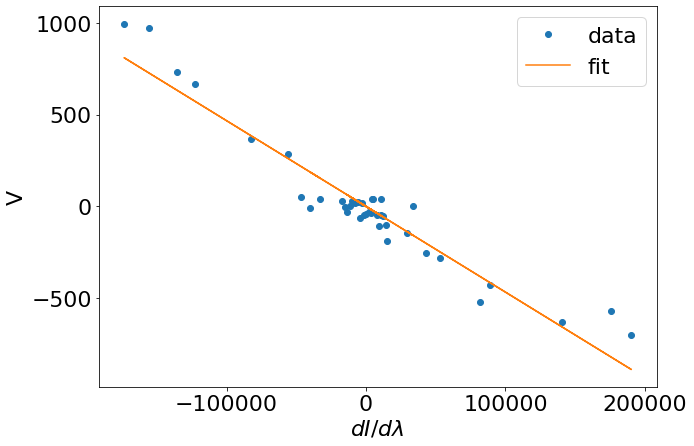

In [57]:
plt.figure(figsize=[10,7])
plt.plot(dI_dl[10:50],stokes[i,j,3,10:50],'o',label='data')
plt.plot(dI_dl[10:50],dI_dl[10:50]*p[0]+p[1],label='fit')
plt.legend()
plt.xlabel("$dI/d\lambda$")
plt.ylabel("V")

Now let's estimate the magnetic field from this. Remember that $k = - 4.69\times 10^{-13} \times B_p \lambda_0^2 g_l$

In [58]:
B = -p[0] / 4.69E-13 / 6301.5**2.0 / 1.67
print (B)

150.37102976770885


Now you can take some time and try out if you get the same result with the second line!

Text(0, 0.5, 'V')

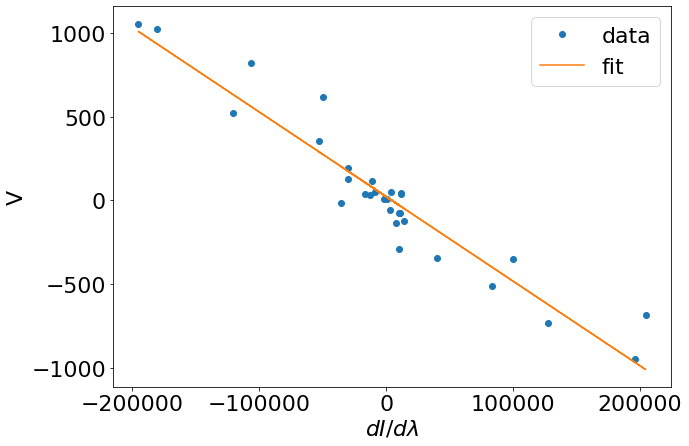

In [66]:
#Let's do the fit
# number of data
ND = 30
a = np.zeros([ND,2])
a[:,0] = dI_dl[60:90]
a[:,1] = 1.0
b = stokes[i,j,3,60:90]

a_inv = np.linalg.pinv(a)

p = np.linalg.inv((a_inv @ a))@ (a_inv @ b)
plt.figure(figsize=[10,7])
plt.plot(dI_dl[60:90],stokes[i,j,3,60:90],'o',label='data')
plt.plot(dI_dl[60:90],dI_dl[60:90]*p[0]+p[1],label='fit')
plt.legend()
plt.xlabel("$dI/d\lambda$")
plt.ylabel("V")

In [67]:
B = -p[0] / 4.69E-13 / 6302.5**2.0 / 2.49
print (B)

108.90737492439125


Now a good question is ... what are our measurement uncertainties!!!! Ok, let's learn that MCMC. For that we will need to explicitly define our likelyhood, prior and posterior. Let's do that. 

In [68]:
#Likelyhood, depends on the function parameters (that can change) and the observations (that are fixed). For convenience we will work
# in log scale

def ln_prior(params):
    # all parameters equally likely
    return 0.

def ln_like(params, x, y, error):
    
    # Remember that gaussian is : p(x) = 1./(sqrt(2 pi) sigma ) exp(-x^2/2sigma^2)
    
    #What model predicts: (error == sigma)
    y_model = params[0] * x + params[1]
    
    chi2 = ((y_model - y) / error)**2
    
    return np.sum((-0.5 * chi2) - 0.5*np.log(2*np.pi) - np.log(error)) # I am making it depend on errors in purpose

def ln_post(params, x, y, error):
    
    lnprior_val = ln_prior(params)
    
    if ~np.isfinite(lnprior_val):
        return lnprior_val
    else:           
        lnlike_val = ln_like(params, x, y, error)
        return lnprior_val + lnlike_val

So now we are sampling. What are we sampling? The posterior, rright! 

In [78]:
ndim = 2 # because we have two parameters 
nwalkers = 50 # this is number of random points

x_data = dI_dl[10:50]
y_data = stokes[i,j,3,10:50]
errors = np.zeros(40)
errors[:] = 100.

starting_params = np.random.uniform(0, 1, ndim*nwalkers).reshape((nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_post,
                                args=[x_data,y_data,errors])

num_steps = 1000
pos, prob, state = sampler.run_mcmc(starting_params, num_steps)

In [79]:
print(sampler.chain.shape)

(50, 1000, 2)


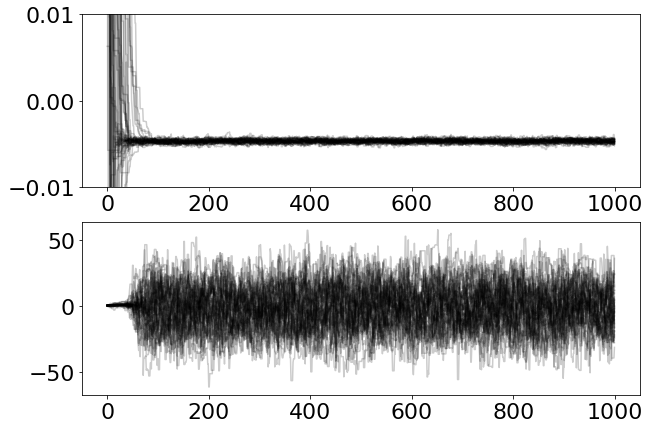

In [80]:
plt.figure(figsize=[10,7])
plt.subplot(211)
plt.plot(sampler.chain[:, :, 0].T, '-k', alpha=0.2)
plt.ylim([-0.01,0.01])
plt.subplot(212)
plt.plot(sampler.chain[:, :, 1].T, '-k', alpha=0.2)

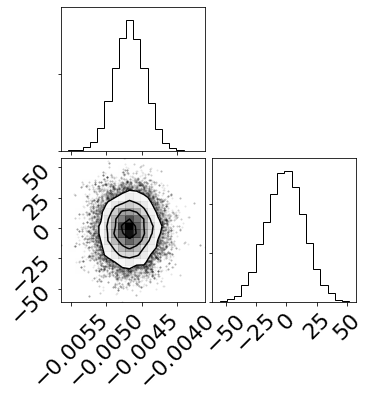

In [81]:
figure = corner.corner(sampler.flatchain[5000:])

Recall that marginalization works like this: 
$$p(k|D) = \int_0^{\infty}p(k,n|D) dn$$

Let's use these distributions to calculate some properties of our inferred parameter. Keep in mind we are only interested in the slope and not in the intercept so we are going to marginalize over the intercept. Thanks to sampling method marginalization is just ignoring parameters we are marginalizing over. 

So:

In [82]:
params = np.squeeze(sampler.flatchain[5000:])
print (params.shape)

(45000, 2)


(array([3.000e+00, 1.300e+01, 6.100e+01, 2.200e+02, 5.450e+02, 1.483e+03,
        3.283e+03, 5.434e+03, 7.389e+03, 8.587e+03, 7.329e+03, 5.416e+03,
        3.138e+03, 1.391e+03, 5.110e+02, 1.520e+02, 2.800e+01, 9.000e+00,
        3.000e+00, 5.000e+00]),
 array([-0.0056347 , -0.00553323, -0.00543177, -0.0053303 , -0.00522884,
        -0.00512737, -0.0050259 , -0.00492444, -0.00482297, -0.00472151,
        -0.00462004, -0.00451857, -0.00441711, -0.00431564, -0.00421418,
        -0.00411271, -0.00401124, -0.00390978, -0.00380831, -0.00370685,
        -0.00360538]),
 <a list of 20 Patch objects>)

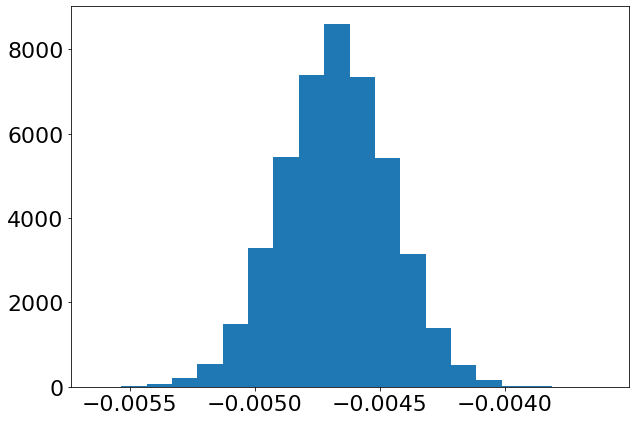

In [83]:
plt.figure(figsize=[10,7])
plt.hist(params[:,0],bins=20)

Makes sense, we saw this up there already. What is now value yo ushould put in your paper? Well, most people would tell you that specifying a confidence interval is good enough. Here I want a 95% confidence interval, say, so I will calculate so called percentiles. I want limits that contain central 95% of my distribution. 

In [86]:
lower = np.percentile(params[:,0],2.5)
median = np.percentile(params[:,0],50.)
upper = np.percentile(params[:,0],97.5)

# Note that magnetic field is directly proportional to the slope
# otherwise I should have used magnetic field as a parameter, directly in the fitting

B = -median / 4.69E-13 / 6301.5**2.0 / 1.67
B_u = -upper / 4.69E-13 / 6301.5**2.0 / 1.67
B_l = -lower / 4.69E-13 / 6301.5**2.0 / 1.67
print (B,B_u-B,B_l-B)

150.28888209641715 -13.399152811272955 13.822884340036893


So our paper would say something like: 

$$ B = 150_{-14}^{+14}\,\mathrm{G} $$

Go now! Do this for every pixel! (You will see it is hard). But we can do it using the approach above. 

Btw, these are always nice to plot:

In [87]:
#Take a sample of straight lines:
indices = np.arange(len(params[:,0]))
random_sample = np.random.choice(indices,200)
to_plot = params[random_sample,:]
print (to_plot.shape)


(200, 2)


Text(0, 0.5, 'V')

<Figure size 720x504 with 0 Axes>

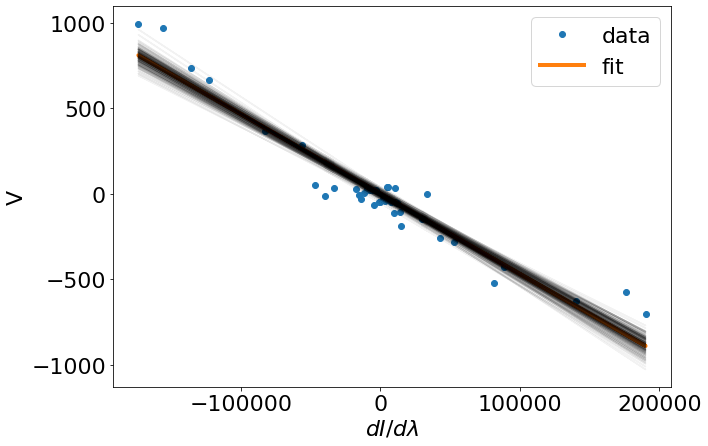

In [88]:
median_slope = np.percentile(params[:,0],50)
median_intercept = np.percentile(params[:,0],50)

plt.figure(figsize=[10,7])
plt.figure(figsize=[10,7])
plt.plot(dI_dl[10:50],stokes[i,j,3,10:50],'o',label='data')
plt.plot(dI_dl[10:50],dI_dl[10:50]*median_slope+median_intercept,linewidth=4,label='fit')
for s in range (0,200):
    plt.plot(dI_dl[10:50],dI_dl[10:50]*to_plot[s,0]+to_plot[s,1],'-k',alpha=0.05)
plt.legend()
plt.xlabel("$dI/d\lambda$")
plt.ylabel("V")

Cool, so, so far we have managed to: 

- Extract a Stokes profile from HINODE cube and see that Stokes V really does look like derivative of Stokes I with wavelength
- Fit a straight line to $V(I')$ dependency, using simple linear system solution. 
- Use a Markov Chain Monte Carlo sampler to sample posterior and perform marginalization and uncertainty esimation.

Now, let's, address noise in more detail. How to infer it? 

(Discuss a bit)

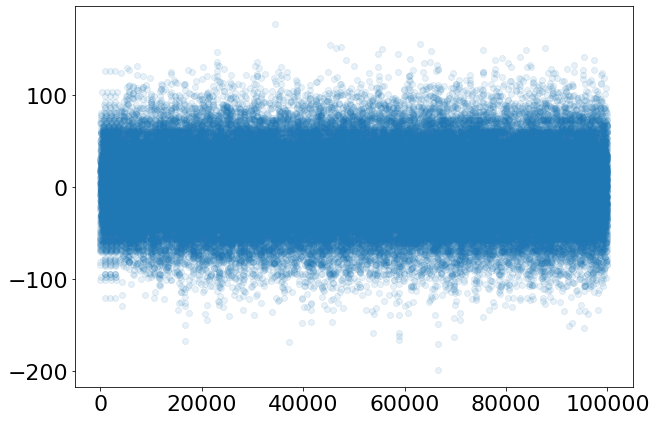

In [89]:
# Yes we can do that: 

V_continuum = stokes[:100,:100,3,-10:].flatten()

plt.figure(figsize=[10,7])
plt.plot(V_continuum,'o',alpha=0.1)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        3.000e+00, 5.000e+00, 3.000e+00, 6.000e+00, 1.100e+01, 1.000e+01,
        1.700e+01, 1.900e+01, 2.800e+01, 2.300e+01, 4.400e+01, 4.100e+01,
        8.200e+01, 1.000e+02, 1.210e+02, 1.450e+02, 1.930e+02, 2.630e+02,
        3.200e+02, 2.940e+02, 4.270e+02, 5.850e+02, 7.370e+02, 6.340e+02,
        1.049e+03, 1.314e+03, 1.431e+03, 1.256e+03, 1.861e+03, 2.089e+03,
        2.415e+03, 2.043e+03, 2.988e+03, 3.173e+03, 3.614e+03, 2.854e+03,
        4.040e+03, 4.114e+03, 4.382e+03, 3.317e+03, 4.489e+03, 4.503e+03,
        4.324e+03, 3.202e+03, 4.180e+03, 3.924e+03, 3.657e+03, 2.603e+03,
        3.304e+03, 2.936e+03, 2.704e+03, 1.707e+03, 1.982e+03, 1.769e+03,
        1.542e+03, 1.015e+03, 1.232e+03, 1.015e+03, 7.460e+02, 5.420e+02,
        5.830e+02, 4.510e+02, 3.500e+02, 1.960e+02, 2.380e+02, 1.630e+02,
        1.300e+02, 8.700e+01, 9.800e+0

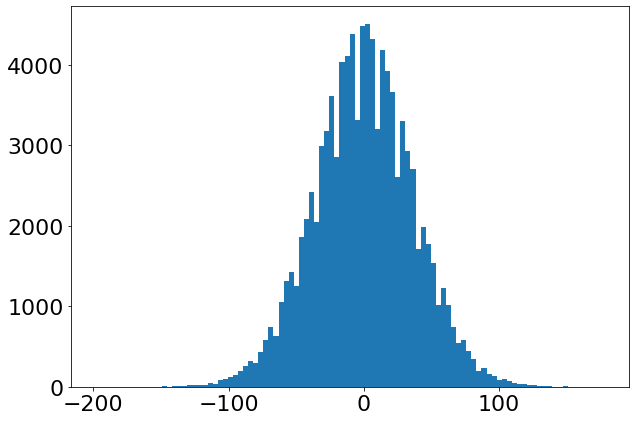

In [91]:
plt.figure(figsize=[10,7])
plt.hist(V_continuum,bins=100)

In [92]:
noise = np.std(V_continuum)
print (noise)

36.59837563518906


In [93]:
errors[:] = noise / 1.41

starting_params = np.random.uniform(0, 1, ndim*nwalkers).reshape((nwalkers, ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_post,
                                args=[x_data,y_data,errors])

# I just want to run :-)
num_steps = 1000
pos, prob, state = sampler.run_mcmc(starting_params, num_steps)



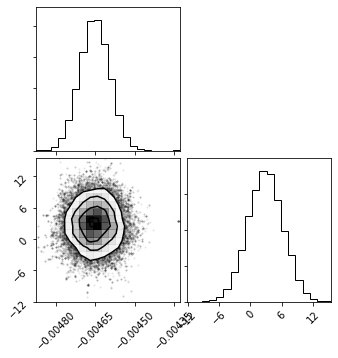

In [26]:
figure = corner.corner(sampler.flatchain[5000:])

In [94]:
params = np.squeeze(sampler.flatchain[5000:])
lower = np.percentile(params[:,0],2.5)
median = np.percentile(params[:,0],50.)
upper = np.percentile(params[:,0],97.5)

B = -median / 4.69E-13 / 6301.5**2.0 / 1.67
B_u = -upper / 4.69E-13 / 6301.5**2.0 / 1.67
B_l = -lower / 4.69E-13 / 6301.5**2.0 / 1.67
print (B,B_u-B,B_l-B)

150.3131032894811 -3.5501930981358782 3.4565106383879822


Note the uncertanties now! Wow, they decreased. That's right, to perform proper inference you need to know your noise properly! 

An interesting thing to try would be to to spend some time trying to infer the noise itself :-) Let's spend some time doing that ;)

Or if what sounds boring let's try fitting using milne eddington model! 